# Init stuff

## Imports

In [149]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [150]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import glob

In [ ]:
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 15
figsize = [30, 15]

## Filecheck

In [ ]:
def FileCheck(fn):
    try:
        open(fn, "r")
        return True
    except IOError:
#         print("Error: File does not appear to exist.")
        return False

# plot Elitist Archive

In [ ]:
def plotAllOnThisServer (algorithms_to_plot, network_unique_evaluations):
    mogomeadir = ""
    lsdir = ""
    rsdir = ""
    nsgadir = ""
    
    prefix = "data/"
    
    for filename in sorted(os.listdir(prefix)):
        if "MO-GOMEA" in filename:
            mogomeadir = prefix + filename
        elif "MO-LS" in filename:
            lsdir = prefix + filename
        elif "MO-RS" in filename:
            rsdir = prefix + filename
        elif "NSGA-II" in filename:
            nsgadir = prefix + filename
    
    print("MO-GOMEA:", mogomeadir)
    print("NSGA-II:", nsgadir)
    print("MO-LS:", lsdir)
    print("MO-RS:", rsdir)
    
    fig, ax = plt.subplots(figsize=(15,15))
    if mogomeadir is not "" and "MO-GOMEA" in algorithms_to_plot:
        plotArchive(ax, mogomeadir, network_unique_evaluations, color="red", label="MO-GOMEA")
    if nsgadir is not "" and "NSGA-II" in algorithms_to_plot:
        plotArchive(ax, nsgadir, network_unique_evaluations, color="green", label="NSGA-II")
    if lsdir is not "" and "MO-LS" in algorithms_to_plot:
        plotArchive(ax, lsdir, network_unique_evaluations, color="blue", label="MO-LS")
    if rsdir is not "" and "MO-RS" in algorithms_to_plot:
        plotArchive(ax, rsdir, network_unique_evaluations, color="orange", label="MO-RS")
        
    ax.legend()
    ax.grid()

plotAllOnThisServer(["MO-LS"], 100)

In [ ]:
def plotArchive(ax, folder, network_unique_evaluations, color, label):
    filename = folder + "/progress0.json"
    if not FileCheck(filename):
        print("File with name", filename, "could not be found.")
        return
    
    with open(filename) as json_file:
        data = json.load(json_file)
#         print(data.keys())
#         print(data["network_unique_evals"])
        index = -1
        max_network_unique_evaluations = -1
        for i in range(len(data["network_unique_evals"])):
            max_network_unique_evaluations = data["network_unique_evals"][i]
            if data["network_unique_evals"][i] == network_unique_evaluations:
                index = i
                break
                
        if index == -1:
            print("Algorithm did not yet do", network_unique_evaluations, "evaluations. Can plot up to", max_network_unique_evaluations, "evaluations.")
            return
                
        archive = data["elitist_archive"][index]
#         print(archive)

        X = np.zeros(len(archive))
        Y = np.zeros(len(archive))
        
        for i in range(len(archive)):
            X[i] = archive[i]['f'][0]
            Y[i] = archive[i]['f'][1]
            
        ax.scatter(X, Y, color=color, label=label)

        
        
    
fig, ax = plt.subplots()
plotArchive(ax, "data/exp20/200314_102842_1584178122666_ARK-Online-2-cifar100_MO-LS-noloop-randdir/", 689, "red", "mols")
ax.legend()
ax.set_xlim(0,1)
ax.set_ylim(0,1)
    

# Calculation of hypervolume (old)

In [ ]:
def calculateHypervolume(archive):
    nparchive = np.zeros((len(archive), 2))
    for i, sol in enumerate(archive):
        nparchive[i, 0] = sol["f"][0]
        nparchive[i, 1] = sol["f"][1]
        
    # Sorting array based on first objective
    sorted_archive = nparchive[np.argsort(nparchive[:, 0])]
    # Reverse array
    sorted_archive = sorted_archive[::-1]

    bottomBoundary = 0
    leftBoundary = 0

    hv = 0
    bottom = bottomBoundary
    for i in range(len(sorted_archive)):
        hv = hv + (sorted_archive[i, 0] - leftBoundary) * (sorted_archive[i, 1] - bottom)
        bottom = sorted_archive[i, 1]

    return hv

## plotting the hypervolume (old)

In [ ]:
def plotHyperVolume(ax, folder, network_unique_evaluations, color, label):
    filename = folder + "/progress0.json"
    if not FileCheck(filename):
        print("File with name", filename, "could not be found.")
        return
    
    
    with open(filename) as json_file:
        data = json.load(json_file)
#         print(data.keys())
#         print(data["network_unique_evals"])

        unique_evals = -1
        new_unique_evals = -1
        max_network_unique_evaluations = -1
        
        hypervolume = np.zeros(network_unique_evaluations)

        for i in range(len(data["network_unique_evals"])):
            new_unique_evals = data["network_unique_evals"][i]
            if new_unique_evals == unique_evals:
                continue
            unique_evals = new_unique_evals
            max_network_unique_evaluations = unique_evals
            
            archive = data["elitist_archive"][i]
            hv = calculateHypervolume(archive)
            hypervolume[unique_evals - 1] = hv
            
            if max_network_unique_evaluations == network_unique_evaluations:
                break
    
        ax.plot(list(range(len(hypervolume))), 1 - hypervolume)
            
fig, ax = plt.subplots(figsize=(10,10))
plotHyperVolume(ax, "data/exp20/200313_102842_1584178122666_ARK-Online-2-cifar100_MO-LS-noloop-randdir/", 50, color="red", label="MO-LS")

# IMPORTANT: Plotting evaluated MMACs of algorithms over time

##### Old stuff

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
fig2, ax2 = plt.subplots(figsize=(20,10))

prefix = "data/meteor02/"
for filedir in sorted(os.listdir(prefix)):
    if 'ARK-Online' in filedir:
        filename = prefix + filedir + "/Progress0.json"
        if not FileCheck(filename):
            print ("Could not find file with name", filename)
            
        if 'MO-GOMEA' in filedir:
            color = "red"
            label = 'MO-GOMEA'
        elif 'NSGA-II' in filedir:
            color = "green"
            label = "NSGA-II"
        elif 'MO-LS' in filedir:
            color = "blue"
            label = "MO-LS"
        elif 'MO-RandomSearch' in filedir:
            color = "orange"
            label = "MO-RS"
        
        with open (filename) as json_file:
            data = json.load(json_file)
            print(data.keys())
#             print(data['network_unique_evals'])
            
            X = []
            Y = []
            
            evals = -1
            for i, e in enumerate(data['network_unique_evals']):
                if int(e) is evals:
#                     print("continue")
                    continue
                evals = int(e)
                X.append(evals)
                Y.append(data['evaluated_solution_fitness'][i][1])
                
            N = 5
            Y = np.convolve(Y, np.ones((N,))/N, mode='same')
                
            ax.plot(X, Y, color=color, label=label)
            ax2.hist(Y, color=color, label=label, bins=20, alpha=0.5)
            
    ax.legend()
    ax.set_xlabel("Unique evaluations")
    ax.set_ylabel("normalized MMACs")
    ax2.legend()
    ax2.set_xlabel("normalized MMACs")
    ax2.set_ylabel("Frequency")

##### New stuff

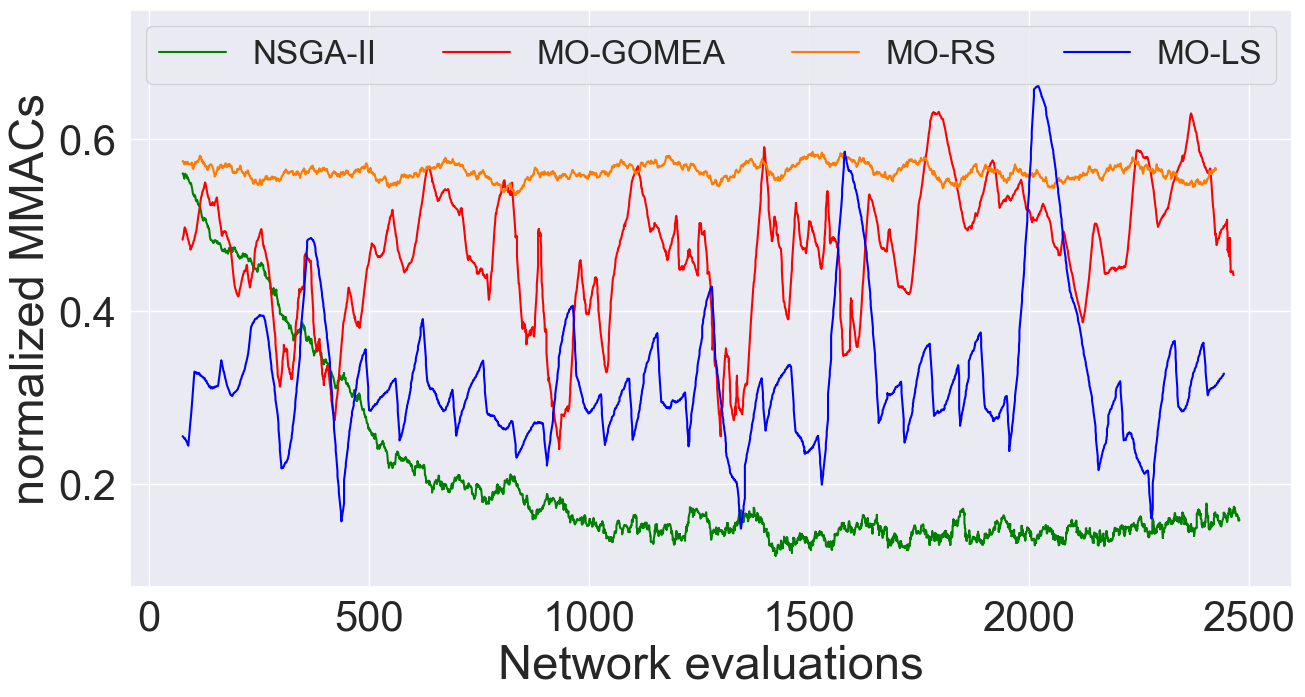

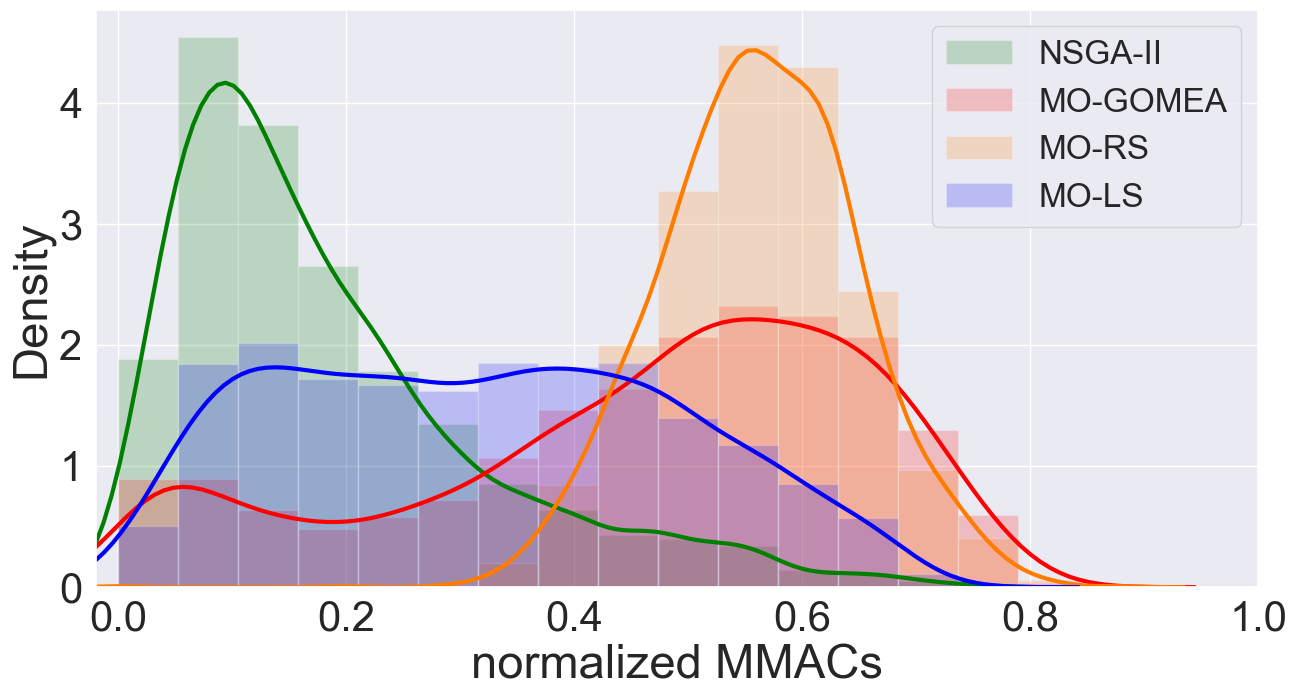

In [20]:
initPlottingStuff(34, 30, 24)
fig, ax = plt.subplots(figsize=(15,7.5))
fig2, ax2 = plt.subplots(figsize=(15,7.5))

version = "v2"
Y_lst = []

for i, algo in enumerate(["NSGA-II", "MO-GOMEA", "MO-RS", "MO-LS"]):
    fn = glob.glob("data/online/"+algo+"_run1_seed*/Progress0.json")[0]
    
    with open (fn) as json_file:
        data = json.load(json_file)
#         print(data.keys())
#             print(data['network_unique_evals'])

        X = []
        Y = []

        evals = -1
        for j, e in enumerate(data['network_unique_evals']):
            if int(e) > 2500:
                break
            if int(e) is evals:
                continue
            evals = int(e)
            X.append(evals)
            Y.append(1 - data['evaluated_solution_fitness'][j][1])

        N = 75
        Yconvolved = np.convolve(Y, np.ones((N,))/N, mode='same')
#         ax.plot(X, Y, color=colors[i], alpha=0.05)
        ax.plot(X[N:-N], Yconvolved[N:-N], color=colors[i], label=algo)
        
        newBins = np.linspace(0,1,20)
#         ax2.hist(Y, color=colors[i], label=algo, bins=20, alpha=0.5)
        if version is "v1":
            sns.distplot(Y, ax=ax2, hist=False, kde=True, bins = newBins, color=colors[i], 
                         kde_kws={'linewidth': 3}, label=algo)
        elif version is "v2":
            sns.distplot(Y, ax=ax2, hist=True, kde=True, bins = newBins, color=colors[i],
                        hist_kws={'alpha': 0.2}, kde_kws={'linewidth': 3}, label=algo)
    Y_lst.append(Y)

if version is "v1":
    ax2.hist(Y_lst, 
             bins = newBins,
             color=colors[:4], 
             density=True,
             alpha=0.2
             )
            
ax.legend()
ax.set_xlabel("Network evaluations")
ax.set_ylabel("normalized MMACs")
ax.legend(loc='upper center', ncol=4)
ax.set_ylim(0.08, 0.75)
ax2.set_xlabel("normalized MMACs")
ax2.set_ylabel("Density")
ax2.set_xlim(-0.02,1)
ax2.legend()

fig.savefig("python/imgs/online_mmac_analysis_plot.pdf", dpi=300, bbox_inches='tight', format='pdf')
fig2.savefig("python/imgs/online_mmac_analysis_hist"+version+".pdf", dpi=300, bbox_inches='tight', format='pdf')


# Analysis of different Local Search algorithms (different methods, different amount of loops

In [ ]:
colors = ["red", "blue", "green", "orange"]
markers = ["x", "o", "^", "v"]

def plotArchiveMOLSExperiment(direction, loopcount):
    for targetEvals in [50, 100, 200, 400, 800]:
        fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(30,5))

        for i in range(5):
            ax[i].set_xlim(0.4, 0.8)
            ax[i].set_ylim(0.5, 1.0)
            ax[i].grid(linewidth=0.2)
            ax[i].set_title("Run " + str(i))
            plt.title(str(targetEvals), loc="right", size="20")

#             for direction in [0.9, 0.95, 1]:
            for loopcount in [2, 3, 4, 1]:
                with open("data/exp21/MO-LS_dir" + str(direction) + "_loop" + str(loopcount) + "/MO_info" + str(i) + ".json") as json_file:
                    data = json.load(json_file)
                    data = data['changes_on_interval']['network_unique_evals']
                    index = -1
                    for idx in range(len(data['evals'])):
                        if targetEvals <= data['evals'][idx]:
                            index = idx
                            evals = data['evals'][idx]
                            break

                    archive = data['elitist_archive_fitness'][index]

                    X = []
                    Y = []

                    for sol in archive:
                        X.append(sol['f'][0])
                        Y.append(sol['f'][1])

#                     if direction == 0.9:
#                         color="red"
#                     elif direction == 0.95:
#                         color="blue"
#                     else:
#                         color="orange"

                    color = colors[loopcount - 1]
                    marker = markers[loopcount - 1]
                    ax[i].scatter(X, Y, s=10, label=(str(direction) + "_" + str(loopcount)), color=color, alpha=0.8, marker=marker)
            ax[i].legend()

plotArchiveMOLSExperiment("rand", 1)

# IMPORTANT: Plotting hypervolume of online experiments

### Imports

In [151]:
import glob
import json
import numpy as np
import os
import matplotlib as mpl
if os.environ.get('DISPLAY','') == '':
    print('no display found. Using non-interactive Agg backend')
    mpl.use('Agg')
import matplotlib.pyplot as plt
import sys

### F: Filecheck

In [152]:
def FileCheck(fn):
    try:
        open(fn, "r")
        return True
    except IOError:
#         print("Error: File does not appear to exist.")
        return False

### F: getTestAcc (from NewVisualization.ipynb)

In [153]:
def transformGenotype(genotype):
    lst = list(genotype)
    for i in [4, 9, 14]:
        lst[i] = transformReductionCell(lst[i])
    joined = "".join(lst)
    joined = joined.replace("0","")
    return joined

def transformReductionCell(encoding):
    if encoding is '0':
        return "P"
    elif encoding is '1':
        return "A"
    elif encoding is '2':
        return "B"
    elif encoding is '3':
        return "C"
    elif encoding is '4':
        return "D"

# transformGenotype("1340123023210311012")

In [154]:
def getTestAcc(genotypes):
    test_accuracies = np.zeros(len(genotypes))
    for i, g in enumerate(genotypes):
        with open("benchmarks/cifar100_results_combined/model_"+transformGenotype(g)+".json") as json_file:
            data = json.load(json_file)
            test_accuracies[i] = data["test_acc"][0] * 0.01
    return test_accuracies

In [155]:
def filterDominatedSolutions(np_archive):
    n = np_archive.shape[0]
    toInclude = np.ones(n, dtype=bool)
    for i in range(n):
        f = np_archive[i]
        for j in range(n):
            if (np_archive[j,0] > f[0] and np_archive[j,1] >= f[1]) or (np_archive[j,0] >= f[0] and np_archive[j,1] > f[1]):
                toInclude[i] = 0
                break
    return (np_archive[toInclude], np_archive[np.invert(toInclude)])
    

### F: Calculation of hypervolume

In [156]:
def calculateHypervolume(archive, plot="validation"):
    np_archive = np.zeros((len(archive), 2))
    genotypes = [""] * len(archive)
    for i, sol in enumerate(archive):
        if plot is "validation":
            np_archive[i, 0] = sol["f"][0]
        elif plot is "test":
            genotypes[i] = sol["g"]
        
        np_archive[i, 1] = sol["f"][1]

    if plot is "test":
        np_archive[:, 0] = getTestAcc(genotypes)
        np_archive, nopes = filterDominatedSolutions(np_archive)

    # Sorting array based on first objective
    sorted_archive = np_archive[np.argsort(np_archive[:, 0])]
    # Reverse array
    sorted_archive = sorted_archive[::-1]

    bottomBoundary = 0
    leftBoundary = 0

    hv = 0
    bottom = bottomBoundary
    for i in range(len(sorted_archive)):
        hv = hv + (sorted_archive[i, 0] - leftBoundary) * (sorted_archive[i, 1] - bottom)
        bottom = sorted_archive[i, 1]

    return hv

### F: plotting hypervolume

In [157]:
def plotHyperVolume(ax, folder, algo, plot_until, plot="validation", color="black", label="undefined", maxruns=6):
    hypervolume = np.zeros((plot_until, maxruns))
    limit_evals = 10**10
    for run in range(maxruns):
        queriedFilename = folder + algo + "_run" + str(run+1) + "_seed*" + "/progress0.json"
        regexFilenames = glob.glob(queriedFilename)
        if len(regexFilenames) == 0:
#             print("File with name", queriedFilename, "could not be found.")
            hypervolume = hypervolume[:, :run]
#             print(hypervolume.shape)
            break
#         print("reading file " + filename)
        filename = regexFilenames[0]

        with open(filename) as json_file:
            data = json.load(json_file)

            unique_evals = -1
            new_unique_evals = -1

            for i in range(len(data["network_unique_evals"])):
                new_unique_evals = data["network_unique_evals"][i]
                if new_unique_evals == unique_evals:
                    continue
                unique_evals = new_unique_evals

                archive = data["elitist_archive"][i]
                hv = calculateHypervolume(archive, plot)
                hypervolume[unique_evals - 1, run] = hv

                if unique_evals == plot_until:
                    break

            if unique_evals < plot_until:
                hypervolume[unique_evals:, run] = hv
                
            limit_evals = min(limit_evals, unique_evals)
#             print(algo, "run",run+1, "is at",unique_evals,"unique_evaluations")

            # Plot every line
#             ax.plot(list(range(unique_evals)), 1 - hypervolume[:unique_evals,run], color=color, label=label+str(run), alpha=0.2)

    print()
    X = list(range(limit_evals))
    
    Y = 1 - hypervolume[:limit_evals]
    
    #plot mean
#     ax.plot(X, np.mean(Y,1), color=color, label=label)
    
    #plot median
    ax.plot(X, np.median(Y, 1), color=color, label=label)

    #plot percentiles
    Ymin = np.percentile(Y, 25, 1)
    Ymax = np.percentile(Y, 75, 1)
    ax.plot(X, Ymin, color=color, ls="dashed", lw=0.5, alpha=0.5)
    ax.plot(X, Ymax, color=color, ls="dashed", lw=0.5, alpha=0.5)
    ax.fill_between(X, Ymin, Ymax, alpha=0.1, color=color)
    
    #plot minmax
#     ax.fill_between(X, np.min(Y,1), 1 - np.max(hypervolume[:limit_evals],1), alpha=0.3, color=color)
    
    #plot std
#     ax.fill_between(X, np.mean(Y,1) - np.std(Y,1), np.mean(Y,1) + np.std(Y,1), alpha=0.3, color=color)    

### F: combine convergence plots of the 4 different algorithms + ACTUAL PLOTTING

##### Plot init

In [158]:
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

In [159]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set()

In [160]:
sns.set_palette("bright")
color_bg_default = "#EAEAF2"
color_bg_inset = (245/256, 245/256, 250/256)
color_zoom_border = "#50668a"
colors = ["green", "red", sns.color_palette()[1], "blue", "orchid"]
def initPlottingStuff(axlabelsize=20, ticklabelsize=18, legendfontsize=20):
    mpl.rcParams['axes.titlesize'] = axlabelsize
    mpl.rcParams['axes.labelsize'] = axlabelsize
    mpl.rcParams['ytick.labelsize'] = ticklabelsize
    mpl.rcParams['xtick.labelsize'] = ticklabelsize
    mpl.rcParams['legend.fontsize'] = legendfontsize
initPlottingStuff(20, 18, 20)
plt.ion()

##### Plot

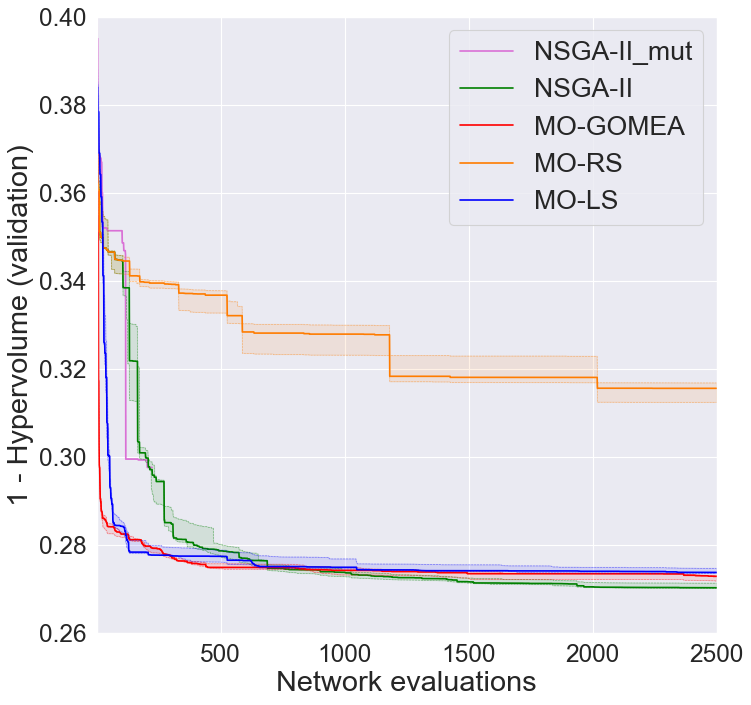

In [166]:
initPlottingStuff(26, 22, 24)
def plotAll (algorithms_to_plot, plot_until, plot="validation"):
    folder = "data/online/"
    global fig, ax
    fig, ax = plt.subplots(figsize=(10,10), dpi=80)

    maxruns = 3
#     plotHyperVolume(ax, folder, "NSGA-II_mut", plot_until, plot=plot, color=colors[4], label="NSGA-II_mut", maxruns=maxruns)
#     plotHyperVolume(ax, folder, "NSGA-II", plot_until, plot=plot, color=colors[0], label="NSGA-II", maxruns=maxruns)
    plotHyperVolume(ax, folder, "MO-GOMEA", plot_until, plot=plot, color=colors[1], label="MO-GOMEA", maxruns=maxruns)
    plotHyperVolume(ax, folder, "MO-RS", plot_until, plot=plot, color=colors[2], label="MO-RS", maxruns=maxruns)
    plotHyperVolume(ax, folder, "MO-LS", plot_until, plot=plot, color=colors[3], label="MO-LS", maxruns=maxruns)

    ax.legend()
#     ax.set_title("CIFAR-100 with online evaluations")
    ax.set_xlim(1, plot_until)
    ax.set_ylim(0.26, 0.4)
    ax.set_xlabel("Network evaluations")
    ax.set_ylabel("1 - Hypervolume ("+plot+")")
#     ax.set_xscale("log")

#     fig.savefig('python/imgs/online_hypervolume.png', dpi = 300, bbox_inches='tight')
#     fig.savefig('python/imgs/online_hypervolume.pdf', dpi = 300, bbox_inches='tight', format='pdf')
    
evaluations = 2500
# print("Hypervolume of different algorithms")
algorithms = ["MO-GOMEA", "NSGA-II", "MO-LS", "MO-RS"]
plot="validation"
plotAll(algorithms, evaluations, plot)
plt.show()

In [ ]:
fig.savefig('python/imgs/online_hypervolume_test.pdf', dpi = 300, bbox_inches='tight', format='pdf')

#### F: gathering evaluated solutions in the online experiment

In [161]:
# Gathers evaluated solutions from the specified algorithms (which = regex {*, MO-GOMEA*, MO-RS*, MO-LS*, NSGA-II*})
def gatherPoints(which, outfilename):
    fns = glob.glob("data/online/" + which + "/progress0.json")  
    solutions = {}
    
    for fn in fns:
        with open(fn) as json_file:
            data = json.load(json_file)
            evaluated_solutions_fitness = data["evaluated_solution_fitness"]
            evaluated_solutions_genotypes = data["evaluated_solution_genotype"]
            for i in range(len(evaluated_solutions_genotypes)):
                solutions[evaluated_solutions_genotypes[i]] = evaluated_solutions_fitness[i]
    
    outfile = "data/online/points_"+outfilename+".json"
    with open(outfile, 'w') as outfile:
        json.dump(solutions, outfile)  

In [ ]:
# gatherPoints("MO-RS*", "RS")

In [ ]:
# gatherPoints("MO-GOMEA*", "MO-GOMEA")
# gatherPoints("MO-LS*", "MO-LS")
# gatherPoints("NSGA-II*", "NSGA-II")
# gatherPoints("MO-RS*", "MO-RS")

In [ ]:
gatherPoints("*", "all_new")

### F: plotting of set of evaluated solutions in the online experiment

In [162]:
# Plots gathered points. Use e.g. plotRandomlySampledPoints(ax, "points_all.json")
def plotPoints(ax, filename, color="grey"):
    with open("data/online/"+filename) as json_file:
        data = json.load(json_file)
        random_solutions = np.zeros((len(data.keys()), 2))
        for i, genotype in enumerate(data):
            random_solutions[i,:] = data[genotype]
            
        
        ax.scatter(random_solutions[:,0], random_solutions[:,1], marker='.', color=color, s=5, alpha=0.1, zorder=1)

In [ ]:
import pandas as pd
# df = pd.DataFrame([[ 1.82716998, -1.75449225],
#  [ 0.09258069,  0.16245259],
#  [ 1.09240926,  0.08617436]], columns=["x", "y"])
def plotKDE(ax, filename, color="grey"):
    with open("data/online/"+filename) as json_file:
        data = json.load(json_file)
        random_solutions = np.zeros((len(data.keys()), 2))
        for i, genotype in enumerate(data):
            random_solutions[i,:] = data[genotype]
            
        df = pd.DataFrame(random_solutions, columns=["x","y"])
        sns.kdeplot(df["x"], df["y"], ax=ax, color=color, shade=True, shade_lowest=False)
#         ax.scatter(random_solutions[:,0], random_solutions[:,1], marker='.', color=color, s=5, alpha=0.1, zorder=1)

In [ ]:
# fig, ax = plt.subplots(1,1,figsize=(5,5))
# plotPoints(ax, "points_all.json")

### F: plotting archive Online

In [163]:
def plotArchiveOnline(ax, algorithm, run, pointInTime, plot="validation", color="black", label="undefined", marker="o"):
    folder = "data/online/"
    queriedFilename = folder + algorithm + "_run" + str(run) + "_seed*" + "/progress0.json"
    filenames = glob.glob(queriedFilename)
    filename = filenames[0]
    
    with open (filename) as json_file:
        data = json.load(json_file)
        
        # This is to find the index in the json at which the unique evaluations is equal to "pointInTime"
        for indexOfData in range(100000):
            if indexOfData >= len(data["network_unique_evals"]):
                print("There are no", pointInTime ,"network unique evaluations yet (data until", data["network_unique_evals"][indexOfData-1],")")
                return
            networkUniqueEvals = data["network_unique_evals"][indexOfData]
            if networkUniqueEvals == pointInTime:
                break
                
        archive = data["elitist_archive"][indexOfData]
        
        np_archive = np.zeros((len(archive), 2))
        genotypes = [""] * len(archive)
        for i, item in enumerate(archive):
            if plot is "validation":
                np_archive[i,0] = item['f'][0]
            elif plot is "test":
                genotypes[i] = item['g']
                
            np_archive[i,1] = item['f'][1]
            
        if plot is "test":
            np_archive[:, 0] = getTestAcc(genotypes)  
            np_archive, nopes = filterDominatedSolutions(np_archive)
            
        np_archive = np_archive[np.argsort(np_archive[:, 1])]

        np_blocky_front = generateBlockyFront(np_archive)
        
        ax.scatter(np_archive[:,0], np_archive[:,1], label=algorithm, color=color, marker=marker, zorder=10, s=25)
        ax.plot(np_blocky_front[:,0], np_blocky_front[:,1], color=color, zorder=5, lw=1, ls=(0, (5, 1)))
#         ax.fill_between(np_blocky_front[:,0], 0, np_blocky_front[:,1], color=color, alpha=0.1)

### F: Generating a blocky front for elitist archive plot

In [164]:
# Generates a np-array that contains the archive's values and their intersection points. This array can be used for plotting the line of the front.
def generateBlockyFront(np_archive):
    np_archive = np_archive[np.argsort(np_archive[:, 1])]
    np_archive = np_archive[np.argsort(np_archive[:, 1][::-1])]
    np_blocky_archive = np.zeros((len(np_archive[:,1]) * 2 + 1, 2))
    
    np_blocky_archive[0,1] = np_archive[0,1]
    i = 0
    for i in range(len(np_archive[:,0])):
        np_blocky_archive[i*2 + 1, :] = np_archive[i,:]
        np_blocky_archive[i*2 + 2, 0] = np_archive[i,0]
        if i != (len(np_archive[:,0]) - 1):
            np_blocky_archive[i*2 + 2, 1] = np_archive[i+1,1]
    
    return np_blocky_archive

### Actual plotting of elitist archive

##### Old plotting stuff

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(10,10))
# evals = 100
# plotArchive(ax, "MO-GOMEA", 1, evals, "red", "o")
# plotArchive(ax, "MO-RS", 1, evals, "orange", "x")
# plotArchive(ax, "MO-LS", 3, evals, "blue", "^")
# plotArchive(ax, "NSGA-II", 2, evals, "green", "v")
# plotPoints(ax, "points_RS.json", color="orange")
# plotPoints(ax, "points_NSGA-II.json", color="green")
# plotPoints(ax, "points_MO-LS.json", color="blue")
# plotPoints(ax, "points_MO-GOMEA.json", color="red")
# ax.set_title("Elitist archives at " + str(evals) + " unique evaluations")
# ax.set_xlabel("Validation accuracy")
# ax.set_ylabel("1 - normalized MMACs")
# ax.set_xlim(0.5, 0.75)
# ax.set_xlim(0, 1)
# ax.set_ylim(0.2, 1.05)
# ax.set_ylim(0, 1)
# ax.legend()

##### New plotting stuff

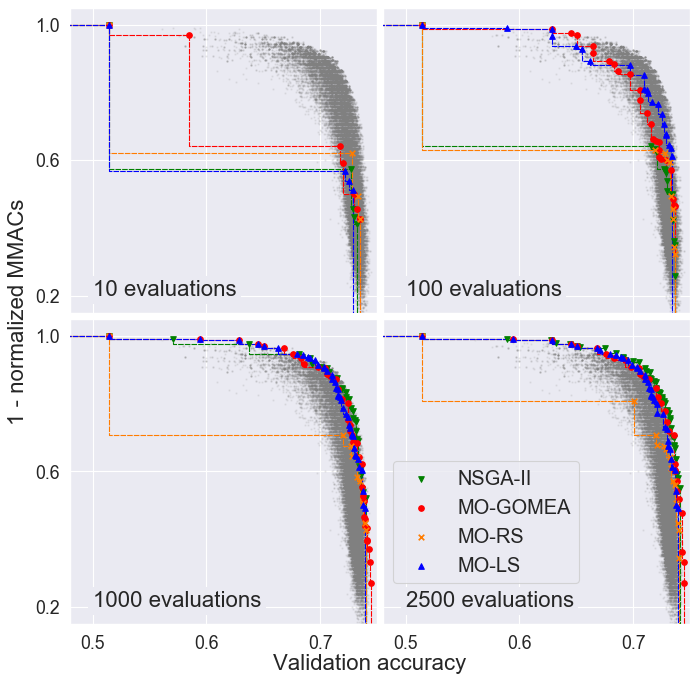

In [425]:
initPlottingStuff(20, 16, 18)

def plotArchives(evals_lst, plot="validation"):
    rows = 2
    columns = 2
    fig, ax_lst = plt.subplots(rows, columns, figsize=(columns * 5, rows * 5), dpi=80, sharex=True, sharey=True)
    if rows is not 1 and columns is not 1:
        ax_lst = [item for row in ax_lst for item in row]
    
    for ax, evals in zip(ax_lst, evals_lst):
            
        plotPoints(ax, "points_all_new.json", color="grey")
        
        plotArchiveOnline(ax, "NSGA-II", 2, evals, plot=plot, color=colors[0], marker="v", label="NSGA-II")
        plotArchiveOnline(ax, "MO-GOMEA", 1, evals, plot=plot, color=colors[1], marker="o", label="MO-GOMEA")
        plotArchiveOnline(ax, "MO-RS", 1, evals, plot=plot, color=colors[2], marker="x", label="MO-RS")
        plotArchiveOnline(ax, "MO-LS", 1, evals, plot=plot, color=colors[3], marker="^", label="MO-LS")

        ax.text(0.5, 0.2, str(evals) + " evaluations", fontsize=20, bbox=dict(facecolor=color_bg_default, \
                                                                              edgecolor="none"))
        ax.set_xlim(0.48, 0.75)
        ax.set_ylim(0.15, 1.05)
            
    # Common axis labels
    fig.text(0.5, 0.06, 'Validation accuracy', ha='center', va='center', fontsize=20)
    fig.text(0.06, 0.5, '1 - normalized MMACs', ha='center', va='center', rotation='vertical', fontsize=20)
    
    ax_lst[2].xaxis.set_major_locator(plt.MaxNLocator(3))
    ax_lst[0].yaxis.set_major_locator(plt.FixedLocator([0.2, 0.6, 1.0]))
    
    ax_lst[3].legend(loc=3, bbox_to_anchor=(0, 0.1))
    
    spacing = 0.02
    plt.subplots_adjust(hspace=spacing, wspace=spacing)
    
#     fig.savefig('python/imgs/online_pareto.png', dpi = 300, bbox_inches='tight')
#     fig.savefig('python/imgs/online_pareto.pdf', dpi = 300, bbox_inches='tight', format='pdf')

plotArchives([10, 100, 1000, 2500], plot="validation")
# plotArchives([10, 100, 1000, 2500], plot="test")

In [ ]:
initPlottingStuff(20, 16, 18)

def plotArchives(evals_lst, plot="validation"):
    rows = 1
    columns = 3
    fig, ax_lst = plt.subplots(rows, columns, figsize=(columns * 5, rows * 5), dpi=80, sharex=True, sharey=True)
    if rows is not 1 and columns is not 1:
        ax_lst = [item for row in ax_lst for item in row]
    
    for ax, evals in zip(ax_lst, evals_lst):
            
        plotPoints(ax, "points_all_new.json", color="grey")
        
        plotArchiveOnline(ax, "NSGA-II", 2, evals, plot=plot, color=colors[0], marker="v", label="NSGA-II")
        plotArchiveOnline(ax, "MO-GOMEA", 1, evals, plot=plot, color=colors[1], marker="o", label="MO-GOMEA")
        plotArchiveOnline(ax, "MO-RS", 1, evals, plot=plot, color=colors[2], marker="x", label="MO-RS")
        plotArchiveOnline(ax, "MO-LS", 1, evals, plot=plot, color=colors[3], marker="^", label="MO-LS")

        ax.text(0.5, 0.2, str(evals) + " evaluations", fontsize=20, bbox=dict(facecolor=color_bg_default, \
                                                                              edgecolor="none"))
        ax.set_xlim(0.48, 0.75)
        ax.set_ylim(0.15, 1.05)
            
    # Common axis labels
    fig.text(0.5, 0, 'Validation accuracy', ha='center', va='center', fontsize=20)
    fig.text(0.085, 0.5, '1 - normalized MMACs', ha='center', va='center', rotation='vertical', fontsize=20)
    
#     ax_lst[2].xaxis.set_major_locator(plt.MaxNLocator(3))
    ax_lst[0].yaxis.set_major_locator(plt.FixedLocator([0.2, 0.6, 1.0]))
    
    ax_lst[2].legend(loc=3, bbox_to_anchor=(0, 0.1))
    
    spacing = 0.02
    plt.subplots_adjust(hspace=spacing, wspace=spacing)
    
    fig.savefig('python/imgs/online_pareto_val_1x3.png', dpi = 300, bbox_inches='tight')
    fig.savefig('python/imgs/online_pareto_val_1x3.pdf', dpi = 300, bbox_inches='tight', format='pdf')

plotArchives([10, 100, 1000], plot="validation")


In [ ]:
initPlottingStuff(20, 16, 18)

def plotArchives(plottypes):
    rows = 1
    columns = 2
    fig, ax_lst = plt.subplots(rows, columns, figsize=(columns * 5, rows * 5), dpi=80, sharex=True, sharey=True)
    if rows is not 1 and columns is not 1:
        ax_lst = [item for row in ax_lst for item in row]
    
    for ax, plot in zip(ax_lst, plottypes):
            
        plotPoints(ax, "points_all_new.json", color="grey")
        evals=2500
        plotArchiveOnline(ax, "NSGA-II", 2, evals, plot=plot, color=colors[0], marker="v", label="NSGA-II")
        plotArchiveOnline(ax, "MO-GOMEA", 1, evals, plot=plot, color=colors[1], marker="o", label="MO-GOMEA")
        plotArchiveOnline(ax, "MO-RS", 1, evals, plot=plot, color=colors[2], marker="x", label="MO-RS")
        plotArchiveOnline(ax, "MO-LS", 1, evals, plot=plot, color=colors[3], marker="^", label="MO-LS")

        ax.text(0.5, 0.2, str(evals) + " evaluations", fontsize=20, bbox=dict(facecolor=color_bg_default, \
                                                                              edgecolor="none"))
        ax.set_xlim(0.48, 0.75)
        ax.set_ylim(0.15, 1.05)
            
    # Common axis labels
    fig.text(0.5, 0, 'Validation accuracy', ha='center', va='center', fontsize=20)
    fig.text(0.06, 0.5, '1 - normalized MMACs', ha='center', va='center', rotation='vertical', fontsize=20)
    
#     ax_lst[2].xaxis.set_major_locator(plt.MaxNLocator(3))
    ax_lst[0].yaxis.set_major_locator(plt.FixedLocator([0.2, 0.6, 1.0]))
    
    ax_lst[1].legend(loc=3, bbox_to_anchor=(0, 0.1))
    
    spacing = 0.02
    plt.subplots_adjust(hspace=spacing, wspace=spacing)
    
    fig.savefig('python/imgs/online_pareto_valtest_1x2.png', dpi = 300, bbox_inches='tight')
    fig.savefig('python/imgs/online_pareto_valtest_1x2.pdf', dpi = 300, bbox_inches='tight', format='pdf')

plotArchives(plottypes=["validation","test"])

In [ ]:
initPlottingStuff()
def plotQueriedPoints():
    rows = 2
    columns = 2
    fig, ax_lst = plt.subplots(rows, columns, figsize=(columns * 5, rows * 5), dpi=80, sharex=True, sharey=True)
    if rows is not 1 and columns is not 1:
        ax_lst = [item for row in ax_lst for item in row]
    
    algo_lst = ["NSGA-II", "MO-GOMEA", "MO-RS", "MO-LS"]
    i = 0
    for ax, algo in zip(ax_lst, algo_lst):
            
#         plotKDE(ax, "points_"+algo+".json", color=colors[i])
        plotPoints(ax, "points_"+algo+".json", color=colors[i])
#         plotArchiveOnline(ax, "NSGA-II", 2, evals, color=colors[0], marker="v", label="NSGA-II")
#         plotArchiveOnline(ax, "MO-GOMEA", 1, evals, color=colors[1], marker="o", label="MO-GOMEA")
#         plotArchiveOnline(ax, "MO-RS", 1, evals, color=colors[2], marker="x", label="MO-RS")
#         plotArchiveOnline(ax, "MO-LS", 1, evals, color=colors[3], marker="^", label="MO-LS")

        ax.text(0.5, 0.2, algo, fontsize=20, bbox=dict(facecolor=color_bg_default, \
                                                                              edgecolor="none"))
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xlim(0.48, 0.75)
        ax.set_ylim(0.15, 1.05)
        i += 1
                    
    # Common axis labels
    fig.text(0.5, 0.06, 'Validation accuracy', ha='center', va='center', fontsize=20)
    fig.text(0.06, 0.5, '1 - normalized MMACs', ha='center', va='center', rotation='vertical', fontsize=20)
    
    ax_lst[2].xaxis.set_major_locator(plt.MaxNLocator(3))
    ax_lst[0].yaxis.set_major_locator(plt.FixedLocator([0.2, 0.6, 1.0]))
    
#     ax_lst[3].legend(loc=3, bbox_to_anchor=(0, 0.1))
    
    spacing = 0.02
    plt.subplots_adjust(hspace=spacing, wspace=spacing)
    
    fig.savefig('python/imgs/online_pareto_points.png', dpi = 300, bbox_inches='tight')
    fig.savefig('python/imgs/online_pareto_points.pdf', dpi = 300, bbox_inches='tight', format='pdf')

plotQueriedPoints()

# Nieuwe meuk

In [457]:
class solution:
    def __init__(self, genotype, f0, f1):
        self.genotype = genotype
        self.f0 = f0
        self.f1 = f1
import operator

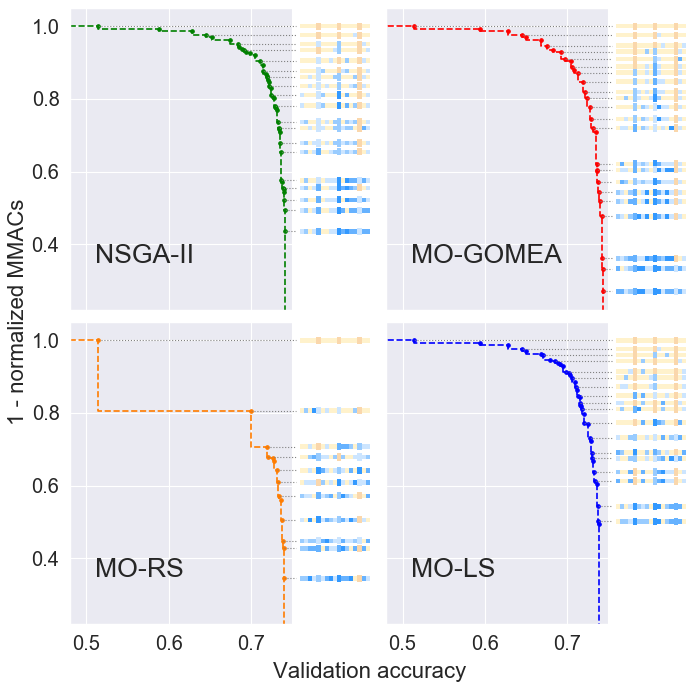

In [494]:
import matplotlib.patches as patches
initPlottingStuff()

files = ["data/online/NSGA-II_run3_*/progress0.json",
        "data/online/MO-GOMEA_run1_*/progress0.json",
        "data/online/MO-RS_run1_*/progress0.json",
        "data/online/MO-LS_run1_*/progress0.json"]
algos = ["NSGA-II", "MO-GOMEA", "MO-RS", "MO-LS"]
evals = 2500

fig, ax_lst = plt.subplots(2,2, figsize=(10,10), dpi=80, sharex=True, sharey=True)
ax_lst = [item for row in ax_lst for item in row]
idx = 0

for fn, ax in zip(files, ax_lst):
    rect = patches.Rectangle((0.75, 0), 2, 2, facecolor="white", alpha=1)
    ax.add_patch(rect)
    ax.text(0.51, 0.35, algos[idx], fontsize=24)
    fn = glob.glob(fn)[0]
    with open(fn) as json_file:
        data = json.load(json_file)
        for i in range(len(data['network_unique_evals'])):
            if data['network_unique_evals'][i] == evals:
                eval_idx = i
                break
        latestArchive_JSON = data["elitist_archive"][eval_idx]
        archive_dict = {}
        archive_data = np.zeros((len(latestArchive_JSON), 2))
        solutions = []
        for i, item in enumerate(latestArchive_JSON):
            archive_dict[item["g"]] = item["f"]
            archive_data[i, 0] = item["f"][0]
            archive_data[i, 1] = item["f"][1]
            solutions.append(solution(item["g"], item["f"][0], item["f"][1]))
            
    ax.scatter(archive_data[:,0], archive_data[:,1], color=colors[idx], s=10)

    blockyFront = generateBlockyFront(archive_data)
    ax.plot(blockyFront[:,0], blockyFront[:,1], color=colors[idx], ls="dashed")
    ax.set_xlim(0.48, 0.85)
    ax.set_ylim(0.22, 1.05)
    drawX = 0.75
    prevY = 20
    threshold = 0.015
    for sol in sorted(solutions, key=operator.attrgetter('f0')):
        x = sol.f0
        y = sol.f1
        if abs(prevY - y) < threshold:
            continue
        prevY = y
        ax.hlines(y, x, drawX + 0.005, color="grey", lw=1, ls="dotted")
        drawEncoding(ax, sol.genotype, drawX, y, 0.005, 0.013, 0)
    idx += 1
    
spacing = 0.04
plt.subplots_adjust(hspace=spacing, wspace=spacing)
ax_lst[2].xaxis.set_major_locator(plt.FixedLocator([0.5, 0.6, 0.7]))

# Common axis labels
fig.text(0.5, 0.05, 'Validation accuracy', ha='center', va='center', fontsize=20)
fig.text(0.06, 0.5, '1 - normalized MMACs', ha='center', va='center', rotation='vertical', fontsize=20)

fig.savefig('python/imgs/online_pareto_networks.pdf', dpi = 300, bbox_inches='tight', format='pdf')


In [481]:
def drawEncoding(ax, encoding, x, y, width, height, angle):
    x0 = x + 0.01
    y0 = y - height/2
    for i, char in enumerate(list(encoding)):
        reductioncell = (i+1) % 5 == 0
        if char == '0':
            if reductioncell:
                color = "#FAD7AC"
            else:
                color = "#FFF2CC"
        elif char == '1':
            color = "#CCE5FF"
        elif char == '2':
            color = "#99CCFF"
        elif char == '3':
            color = "#66B2FF"
        elif char == '4':
            color = "#3399FF"
        if reductioncell:
            newheight = height * 1.5
        else:
            newheight = height
        
#         newX = x + (i * width) + 0.01
#         newY = y - newheight/2
        newX, newY = getRotatedCoordinates(x + (i * width) + 0.01, y - newheight/2, x0, y0, angle)
        rect = patches.Rectangle((newX, newY), width, newheight, linewidth=0, facecolor=color, angle=angle)
#         rect = patches.Rectangle((0, 0), .5, .5, linewidth=0, facecolor=color, angle=0)
#         t2 = mpl.transforms.Affine2D().rotate_deg(-45) + ax.transData
#         print(t2)
#         rect.set_transform(t2)
        ax.add_patch(rect)
    

In [ ]:
import math
def getRotatedCoordinates(x, y, x0, y0, angle_degrees):
    angle = math.radians(angle_degrees)
    newX = (x-x0) * math.cos(angle) - (y-y0) * math.sin(angle)
    newY = (y-y0) * math.cos(angle) + (x-x0) * math.sin(angle)
    return newX + x0, newY + y0

-1.0 1.0000000000000002


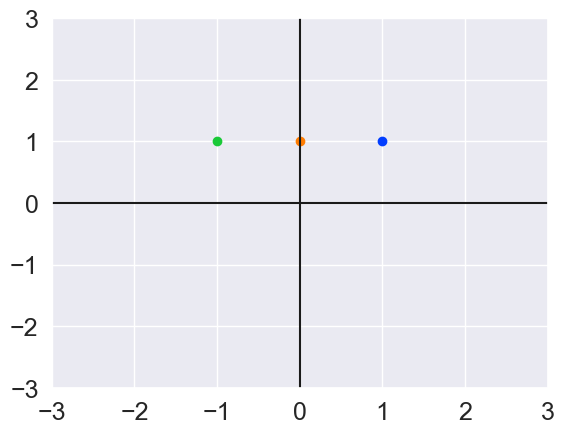

In [281]:
x, y = 1, 1
x0, y0 = 0, 1
plt.scatter(x, y)
ax = plt.gca()
ax.hlines(0, -3, 3)
ax.vlines(0, -3, 3)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.scatter(x0,y0)
a, b = getRotatedCoordinates(x, y, x0, y0, 180)
ax.scatter(a,b)
print(a,b)

# Finding the minimum and maximum fitness value for MMACS

In [ ]:
fns = glob.glob("data/online/*/progress0.json")
print(fns)
arr = []
for fn in fns:
    with open (fn) as json_file:
        data = json.load(json_file)
        for item in data["evaluated_solution_fitness"]:
            arr.append(item[1])
#             print(item[1])
# #             break
print(min(arr))

# Analysis of MMAC values in the benchmark set

In [ ]:
with open ("benchmarks/ark7/ark7_MO.json") as json_file:
    data = json.load(json_file)

In [ ]:
val_acc = []
mmacs = []
genotypes = []
maxmmacs = -1
maxgenotype = ""
maxacc = -1
for i, item in enumerate(data):
    val_acc.append(data[item]['val_acc'])
    mmacs.append(data[item]['MMACs'])
    genotypes.append(item)
    if data[item]['MMACs'] > maxmmacs:
        maxmmacs = data[item]['MMACs']
        print (maxmmacs, item)
    if data[item]['val_acc'] > maxacc:
        maxacc = data[item]['val_acc']
        print(maxacc, item)
        
#     if i == 10:
#         break

In [ ]:
print(np.min(mmacs))
print(np.max(mmacs))

In [ ]:
plt.hist(np.array(mmacs) [np.array(mmacs) > 200], bins=50)

In [ ]:
1 - (200 - 21) / (239 - 21)